# Imports

In [57]:
# Remember to login to wandb!
import sys
import os 
import torch
import matplotlib.pyplot as plt
import copy 
# Append module directory for imports
parent_dir = os.path.expanduser('../eigenestimation')
sys.path.append(parent_dir)

from eigenestimation.toy_models.tms import AutoencoderSymmetric, AutoencoderParallel  # Import your model
from eigenestimation.evaluation.networks import DrawNeuralNetwork
from eigenestimation.eigenmodel.eigenmodel import EigenModel
from eigenestimation.utils.loss import MSELoss
from eigenestimation.toy_models.data import GenerateTMSInputs

import figure_names

In [58]:
model_path = "../outputs/toy_models/circuit_superposition.pt"
eigenmodel_path = "../outputs/eigenmodels/circuit_superposition.pt"
model = torch.load(model_path)['model']
eigenmodel = torch.load(eigenmodel_path)

# Initial Model

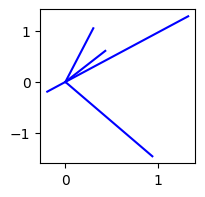

In [59]:
# Load TMS model

# Plot TMS representations.
en = copy.deepcopy(model.W_out).detach().cpu().numpy().transpose()

plt.figure(figsize=(2,2))
for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'b-')
plt.show()

<Axes: title={'center': 'subnetwork sum'}>

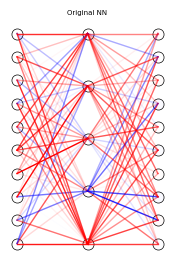

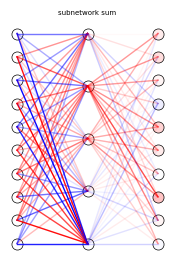

In [60]:
model_params = dict(model.named_parameters())
weights = {k:v for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v.transpose(0,1) for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}

f, ax = plt.subplots(figsize=(2,3))
DrawNeuralNetwork(weights, biases, "Original NN", ax=ax)


checkpoint = torch.load(eigenmodel_path)
eigenmodel = checkpoint['model']


model_params = eigenmodel.reconstruct_network()
weights = {k:v.transpose(0,1) for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}

f, ax = plt.subplots(figsize=(2,3))
DrawNeuralNetwork(weights, biases, title='subnetwork sum', ax=ax)


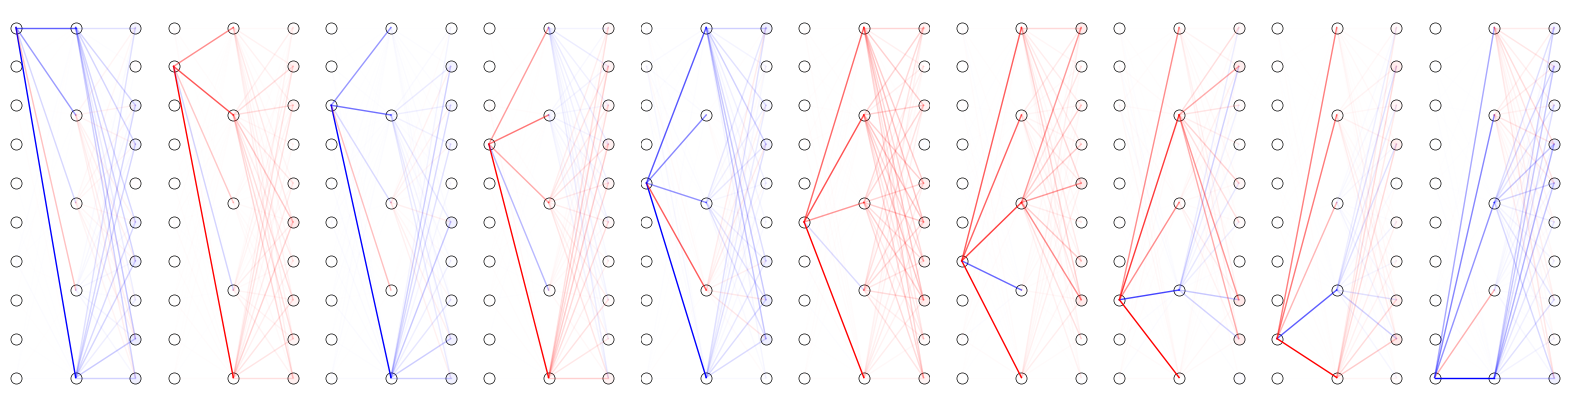

In [61]:
f, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=10)
axes_flat = axes.flatten()
for i, network in enumerate(eigenmodel.construct_subnetworks()):
    weights = {k:v.transpose(0,1) for k,v in network.items() if 'b' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'b' in k}
    biases = {str(i+1):v for i,v in enumerate(biases.values())}
    feature_idx = weights['0'].abs().sum(dim=0).argmax()
    DrawNeuralNetwork(weights, biases, ax=axes_flat[9-feature_idx])
    
# Save as high_rank_subnetwork_{i}.svg
f.savefig(figure_names.circuit_superposition_decomposition, transparent=True, bbox_inches='tight')
f.savefig(figure_names.circuit_superposition_decomposition.replace('.pdf', '.svg'), transparent=True, bbox_inches='tight')

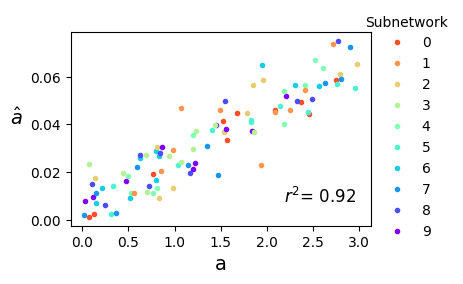

In [62]:
# Get subnetworks
subnetworks = eigenmodel.construct_subnetworks()
coefs = torch.load(model_path.replace('.pt','_coefs.pt')).detach().cpu().numpy()
full_network = eigenmodel.reconstruct_network()
# Load coefficeints
# SHow with numpy
import numpy as np
pred_coeffs_concat = []
true_coeffs_concat = []
plt.figure(figsize=(5,3))

for i in range(len(subnetworks)):
    # Circulate through colors
    pred_coeffs = (subnetworks[i]['W_in'] @ subnetworks[i]['W_out']).cpu().detach().numpy()
    
    feature_idx = abs(pred_coeffs).sum(axis=1).argmax()
    color = plt.cm.rainbow(feature_idx/len(subnetworks))

    pred_coeffs = pred_coeffs[feature_idx,:]
    actual_coeffs = coefs[feature_idx,:]
    pred_coeffs_concat.append(pred_coeffs)
    true_coeffs_concat.append(actual_coeffs)
    plt.plot(actual_coeffs, pred_coeffs , '.', color=color, label={9-feature_idx})

# print correlation between true coefficients and predicted coefficients
# Format as a string and round to 2 decimal places
# Print int he bottom right corner
plt.text(0.95, 0.1, f'$r^2$= {np.corrcoef(np.concatenate(pred_coeffs_concat), np.concatenate(true_coeffs_concat))[0,1]:.2f}', ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=12)
# Order legend in alphabetical order

# Get legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# Sort the legend entries alphabetically
sorted_indices = np.argsort(labels)
sorted_handles = [handles[i] for i in sorted_indices]
sorted_labels = [labels[i] for i in sorted_indices]

# Add the sorted legend
plt.legend(sorted_handles, sorted_labels,loc='upper right', bbox_to_anchor=(1.3, 1.15), title='Subnetwork', frameon=False)
plt.ylabel('$\hat{a}$', rotation=0, labelpad=10, fontsize=14)
plt.xlabel('a', fontsize=14)
plt.tight_layout()
plt.savefig(figure_names.circuit_superposition_coefficients, transparent=True, bbox_inches='tight')
plt.savefig(figure_names.circuit_superposition_coefficients.replace('.pdf', '.svg'), transparent=True, bbox_inches='tight')
plt.show()